In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 2

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
class SimpsonCNN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # 224
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 110
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        # 54
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 26
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        # 12
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 5        
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, n_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop1(self.conv2(x))
        x = self.conv3(x)
        x = self.drop2(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 256)
        x = self.drop3(self.fc1(x))        
        x = self.fc2(x)        
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.AdamW(model.parameters())
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    opt, mode='max', factor=0.1, patience=10, verbose=False)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            #scheduler.step(val_acc)
            scheduler.step()
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [9]:
n_classes = len(np.unique(train_val_labels))
print(n_classes)
clf = SimpsonCNN(n_classes).to(DEVICE)
#clf = ConvModel(n_classes).to(DEVICE)
#print(clf)
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))


42
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
              ReLU-2         [-1, 32, 220, 220]               0
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 32, 108, 108]           9,248
              ReLU-5         [-1, 32, 108, 108]               0
         MaxPool2d-6           [-1, 32, 54, 54]               0
         Dropout2d-7           [-1, 32, 54, 54]               0
            Conv2d-8           [-1, 64, 52, 52]          18,496
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
        Dropout2d-14          [-1, 1

In [10]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [11]:
submit = pd.DataFrame(columns=['Id'])


FOLD 1


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 3.3725733015160997


epoch:   3%|██▌                                                                         | 1/30 [01:10<34:00, 70.37s/it]


Epoch 001 train_loss: 3.3726     val_loss 2.7196 train_acc 0.1553 val_acc 0.2757
loss 2.5961823090658998


epoch:   7%|█████                                                                       | 2/30 [02:20<32:45, 70.19s/it]


Epoch 002 train_loss: 2.5962     val_loss 2.4528 train_acc 0.2961 val_acc 0.3375
loss 2.2364011749449544


epoch:  10%|███████▌                                                                    | 3/30 [03:29<31:29, 69.98s/it]


Epoch 003 train_loss: 2.2364     val_loss 2.1204 train_acc 0.3976 val_acc 0.4365
loss 1.9452939896721688


epoch:  13%|██████████▏                                                                 | 4/30 [04:39<30:17, 69.91s/it]


Epoch 004 train_loss: 1.9453     val_loss 1.9192 train_acc 0.4807 val_acc 0.4871
loss 1.6896450500497868


epoch:  17%|████████████▋                                                               | 5/30 [05:49<29:08, 69.94s/it]


Epoch 005 train_loss: 1.6896     val_loss 1.6821 train_acc 0.5390 val_acc 0.5473
loss 1.4996843658939834


epoch:  20%|███████████████▏                                                            | 6/30 [06:59<27:58, 69.94s/it]


Epoch 006 train_loss: 1.4997     val_loss 1.5413 train_acc 0.5887 val_acc 0.5895
loss 1.2910760103278172


epoch:  23%|█████████████████▋                                                          | 7/30 [08:09<26:47, 69.88s/it]


Epoch 007 train_loss: 1.2911     val_loss 1.4637 train_acc 0.6409 val_acc 0.6024
loss 1.0163032756877493


epoch:  27%|████████████████████▎                                                       | 8/30 [09:18<25:36, 69.86s/it]


Epoch 008 train_loss: 1.0163     val_loss 1.2895 train_acc 0.7174 val_acc 0.6605
loss 0.9479479206705359


epoch:  30%|██████████████████████▊                                                     | 9/30 [10:30<24:39, 70.45s/it]


Epoch 009 train_loss: 0.9479     val_loss 1.2604 train_acc 0.7391 val_acc 0.6683
loss 0.9137550944723356


epoch:  33%|█████████████████████████                                                  | 10/30 [11:41<23:33, 70.66s/it]


Epoch 010 train_loss: 0.9138     val_loss 1.2484 train_acc 0.7542 val_acc 0.6696
loss 0.8820014826222855


epoch:  37%|███████████████████████████▍                                               | 11/30 [12:51<22:17, 70.38s/it]


Epoch 011 train_loss: 0.8820     val_loss 1.2311 train_acc 0.7588 val_acc 0.6776
loss 0.8642615832250188


epoch:  40%|██████████████████████████████                                             | 12/30 [14:01<21:04, 70.25s/it]


Epoch 012 train_loss: 0.8643     val_loss 1.2239 train_acc 0.7647 val_acc 0.6784
loss 0.8359479830533683


epoch:  43%|████████████████████████████████▌                                          | 13/30 [15:11<19:54, 70.26s/it]


Epoch 013 train_loss: 0.8359     val_loss 1.2105 train_acc 0.7714 val_acc 0.6842
loss 0.8081777224013021


epoch:  47%|███████████████████████████████████                                        | 14/30 [16:22<18:48, 70.51s/it]


Epoch 014 train_loss: 0.8082     val_loss 1.2072 train_acc 0.7789 val_acc 0.6870
loss 0.7744693256956148


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [17:33<17:37, 70.51s/it]


Epoch 015 train_loss: 0.7745     val_loss 1.1979 train_acc 0.7879 val_acc 0.6861
loss 0.7662465915289502


epoch:  53%|████████████████████████████████████████                                   | 16/30 [18:44<16:28, 70.58s/it]


Epoch 016 train_loss: 0.7662     val_loss 1.1940 train_acc 0.7938 val_acc 0.6944
loss 0.7628799965794928


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [19:57<15:28, 71.45s/it]


Epoch 017 train_loss: 0.7629     val_loss 1.2033 train_acc 0.7955 val_acc 0.6859
loss 0.7605175880941124


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [21:12<14:27, 72.33s/it]


Epoch 018 train_loss: 0.7605     val_loss 1.1976 train_acc 0.7959 val_acc 0.6901
loss 0.7570236602344145


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [22:27<13:24, 73.17s/it]


Epoch 019 train_loss: 0.7570     val_loss 1.1901 train_acc 0.7976 val_acc 0.6901
loss 0.7629383169111186


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [23:41<12:14, 73.47s/it]


Epoch 020 train_loss: 0.7629     val_loss 1.1834 train_acc 0.7958 val_acc 0.6933
loss 0.7526887512278929


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [24:56<11:06, 74.04s/it]


Epoch 021 train_loss: 0.7527     val_loss 1.2013 train_acc 0.7981 val_acc 0.6905
loss 0.7473929828736002


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [26:13<09:57, 74.72s/it]


Epoch 022 train_loss: 0.7474     val_loss 1.1985 train_acc 0.7966 val_acc 0.6887
loss 0.7503385701835739


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [27:26<08:39, 74.22s/it]


Epoch 023 train_loss: 0.7503     val_loss 1.1881 train_acc 0.7949 val_acc 0.6932
loss 0.7485490037875736


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [28:39<07:23, 73.87s/it]


Epoch 024 train_loss: 0.7485     val_loss 1.1929 train_acc 0.7980 val_acc 0.6900
loss 0.7412097308967532


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [29:59<06:19, 75.87s/it]


Epoch 025 train_loss: 0.7412     val_loss 1.1915 train_acc 0.8040 val_acc 0.6901
loss 0.7528282274856086


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [31:18<05:07, 76.82s/it]


Epoch 026 train_loss: 0.7528     val_loss 1.1974 train_acc 0.7961 val_acc 0.6865
loss 0.7394298330353806


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [32:38<03:52, 77.59s/it]


Epoch 027 train_loss: 0.7394     val_loss 1.1925 train_acc 0.8027 val_acc 0.6885
loss 0.7529035073621698


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [33:54<02:34, 77.37s/it]


Epoch 028 train_loss: 0.7529     val_loss 1.1923 train_acc 0.7996 val_acc 0.6908
loss 0.737006472525971


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [35:09<01:16, 76.48s/it]


Epoch 029 train_loss: 0.7370     val_loss 1.1951 train_acc 0.8039 val_acc 0.6923
loss 0.7499805970241195


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [36:25<00:00, 72.86s/it]


Epoch 030 train_loss: 0.7500     val_loss 1.1904 train_acc 0.7980 val_acc 0.6894


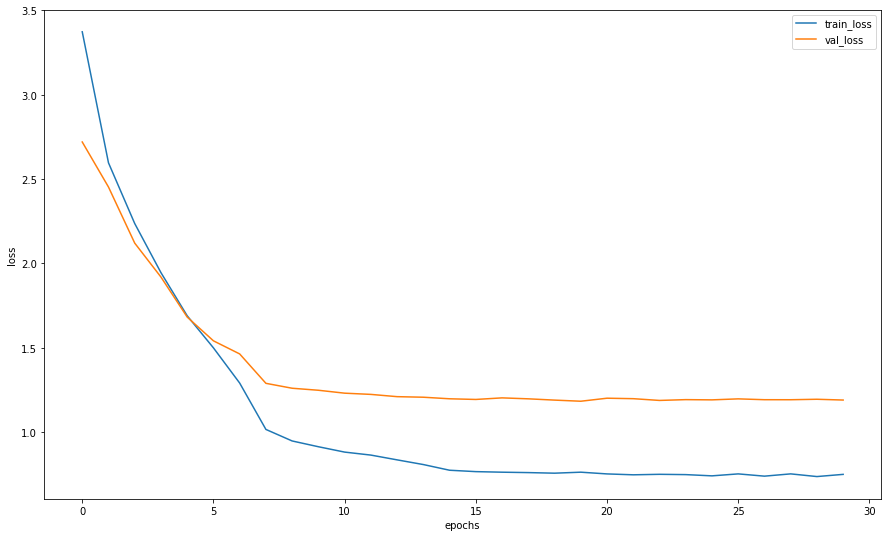

In [12]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = SimpsonCNN(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds
    break

In [13]:
torch.cuda.empty_cache()

###  Submission

In [14]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('submission_custom_kfold_sgd-3_lrs.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,barney_gumble,barney_gumble
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
